<p style="font-family: Arial; font-size:3.0em;color:yellow; font-style:bold"><br>
Uncapacitated Facility Location Problem
</p><br>

<p style="text-align:center; font-family: Arial; font-size:2.00em;color:cyan; font-style:bold"><br>
Dr. Hoa Bui
</p><br>

<p style="text-align:center; font-family: Arial; font-size:1.00em;color:white; font-style:bold">Originally created for: </p>

<p style="text-align:center; font-family: Arial; font-size:1.00em;color:green; font-style:bold">
Mathematical Optimisation: Theory and Application, AMSI Summer School 2026</p>

<br>
<br>


In [2]:
import numpy as np
import gurobipy as gp
from gurobipy import Model, GRB
import matplotlib.pyplot as plt
from termcolor import colored

# Problem description
Given a set of potential facilities $N=\{1,\ldots,n\}$ and a set of customers $M=\{1,\ldots,p\}$. Each facility $i$ has an associated fixed cost $c_i$ to open, and if customer $j$ receives service from facility $i$, a transportation cost $a_{ij}$ will incur. 

We find a solution of opening facilities and assigning customers to facilities so that the total cost is minimized.

The uncapacitated facility location problem is formulated as follows:

$$\begin{aligned}
\min\quad & \sum_{i=1}^n\sum_{j=1}^pa_{ij}y_{ij} +\sum_{i=1}^n c_ix_i \\
\text{s.t.}\quad & \sum_{i=1}^n y_{ij}\ge 1,\quad j = 1,\ldots,p\\
& y_{ij} \le x_i,\quad i=1,\ldots,n,\; j=1,\ldots,p\\
& y_{ij}\ge 0,\; x_{i}\in \{0,1\}
\end{aligned}$$

1. Variables $x_i\in \{0,1\}$ decide whether facility $i$ will be opened.

2. Variables $y_{ij}\ge 0$ decide the fraction of customer $j$'s demand served by facility $i$.

3. The objective minimizes the total transportation cost plus the fixed cost of opening facilities.

4. The first constraint ensures that each customer $j$ is fully served (by at least one facility).

5. The second constraint ensures that customer $j$ can receive service from facility $i$ only when facility $i$ is opened.

# Generate some input data
1. Number of facility
2. Number of customers
3. Fixed cost to open a facility
4. Transportation cost to serve customer j by a facility i

In [3]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of possible facilities
n = 100

# Number of customers
p = 500

# Generate 2D locations for facilities (x, y coordinates)
facility_locations = np.random.uniform(0, 100, size=(n, 2))

# Generate 2D locations for customers (x, y coordinates)
customer_locations = np.random.uniform(0, 100, size=(p, 2))

# Associated cost to open a facility
facility_cost = 1000 * np.random.randint(10, 100, size=n)  # c_i

# Calculate coordinate differences for all facility-customer pairs
coordinate_differences = (
    facility_locations[:, np.newaxis, :] - customer_locations[np.newaxis, :, :]
)  # Shape: (n, p, 2)

# Calculate squared distances and take squared Euclidean distances
transportation_cost = np.sum(coordinate_differences**2, axis=2)  # Shape: (n, p)

# Plot the facilities and customer locations

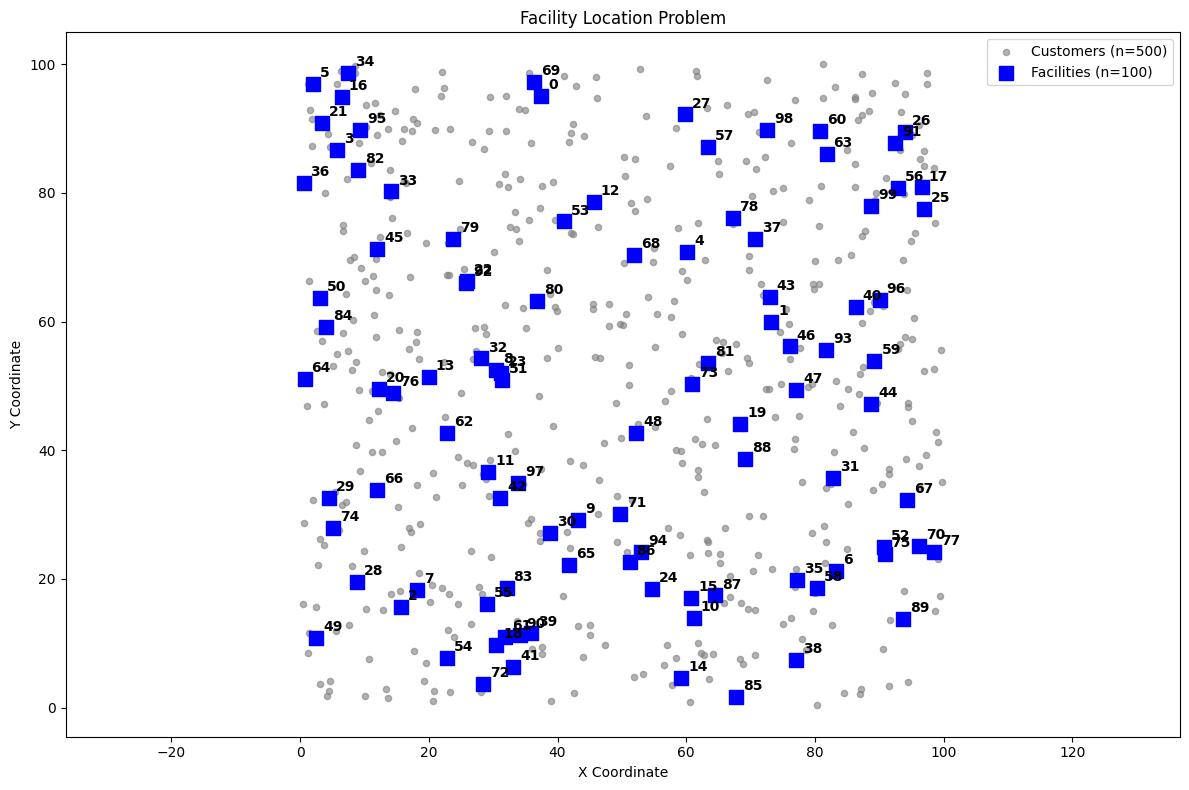

In [4]:
# Create visualization of facilities and customers
plt.figure(figsize=(12, 8))

# Plot customers in gray
plt.scatter(
    customer_locations[:, 0],
    customer_locations[:, 1],
    c="gray",
    s=20,
    alpha=0.6,
    label=f"Customers (n={p})",
)

# Plot facilities in blue
plt.scatter(
    facility_locations[:, 0],
    facility_locations[:, 1],
    c="blue",
    s=100,
    marker="s",
    label=f"Facilities (n={n})",
)

# Add facility numbers as annotations
for i, (x, y) in enumerate(facility_locations):
    plt.annotate(
        str(i),
        (x, y),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=10,
        fontweight="bold",
    )

plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Facility Location Problem")
plt.legend()
plt.axis("equal")
plt.tight_layout()
plt.show()

# Decomposition model

Master Problem
$$\begin{aligned}
\min\quad & \theta + \sum_{i=1}^n d_ix_i\\
\text{s.t.}\quad & \text{optimality cuts}\\
& x_{i}\in \{0,1\}
\end{aligned}$$

The decision variables of the master problem is $x_i$, whether the facility $i$ will be built.

In [5]:
# Setup model
m = Model(name="master problem")

# Don't print Gurobi output
m.setParam("OutputFlag", 0)

# Set binary variables
x = m.addVars(n, vtype=GRB.BINARY, name="x")

# Set continuous variables
y = m.addVars(n, p, vtype=GRB.CONTINUOUS, name="y")

# Set theta
theta = m.addVar(vtype=GRB.CONTINUOUS, name="theta")

# Add auxiliary constraint
m.addConstr(sum(x[i] for i in range(n)) >= 1)

# Objective function
m.setObjective(
    theta + gp.quicksum(facility_cost[i] * x[i] for i in range(n)), GRB.MINIMIZE
)

Set parameter Username
Set parameter LicenseID to value 2630841
Set parameter LicenseID to value 2630841
Academic license - for non-commercial use only - expires 2026-03-04
Academic license - for non-commercial use only - expires 2026-03-04


# Subproblem

At each iteration, once the solution $x^k$ of the master problem is determined, i.e., we know which facilities will be built. The subproblem will then determine which customer will be served by which facilities. Note that the decision variables of the subproblem is only $y_{ij}$.

**Subproblem:**
$$\begin{aligned}
\min\quad & \sum_{i=1}^n\sum_{j=1}^pa_{ij}y_{ij} \\
\text{s.t.}\quad & \sum_{i=1}^n y_{ij}\ge 1,\quad j = 1,\ldots,p\\
& y_{ij} \le x_i^k,\quad i=1,\ldots,n,\; j=1,\ldots,p\\
& y_{ij}\ge 0
\end{aligned}$$

**Dual of the subproblem:**
$$\begin{aligned}
\max \quad & \sum_{j=1}^p\left(\lambda_j +\sum_{i=1}^n x_i^k\pi_{ij}\right)\\
\text{s.t.}\quad & \lambda_j + \pi_{ij} \le a_{ij},\quad i = 1,\ldots,n,\; j=1,\ldots,p\\
& \lambda_j \ge 0,\; \pi_{ij}\le 0,\quad i=1,\ldots,n,\; j = 1,\ldots,p
\end{aligned}$$

The subproblem can be solved analytically (Balinski 1965), and one of the optimality cuts is:

**1. Optimality cut:**
$$\theta \ge \sum_{j=1}^p \left(\lambda_j^k +\sum_{i=1}^n \pi_{ij}^kx_i\right) =\sum_{i=1}^n\sum_{j=1}^p \pi_{ij}^k x_i+\sum_{j=1}^p\lambda_j^k$$

where
$$\lambda_j^k = \min\{a_{ij}:\; x_i^k=1 \}$$

and
$$\pi_{ij}^k = \begin{cases}
0,&\quad x_i^k=1\\
\min\{0, a_{ij} - \lambda_j^k\},& \quad x_i^k=0
\end{cases}$$

**2. Interpretation of dual variables:**

- $\lambda_j^k$ is the cost of servicing customer $j$ given the selection $x^k$.
- $\pi_{ij}^k$ is a miss-opportunity cost if facility $i$ could have been built instead (note that $x_i^k = 0$).

In [6]:
def get_lambda(x: np.array, transportation_cost: np.array) -> np.array:
    """Calculate the minimum transportation cost for each customer given open facilities.

    For each customer j, finds the minimum transportation cost among all open facilities.
    This represents the cost of serving customer j optimally given the current facility
    configuration x.

    Args:
        x: Binary array of shape (n,) indicating which facilities are open (1) or closed (0).
        transportation_cost: Array of shape (n, p) where element [i,j] is the cost
            of serving customer j from facility i.

    Returns:
        Array of shape (p,) where element j is the minimum cost to serve customer j
        from any open facility.

    """
    return np.array(
        [
            min(transportation_cost[i, j] for i in range(n) if x[i] == 1)
            for j in range(p)
        ]
    )


def get_pi(x: np.array, transportation_cost: np.array, lambda_k: np.array) -> np.array:
    """Calculate the dual variables pi for closed facilities in Benders decomposition.

    For each closed facility i and customer j, calculates the opportunity cost
    pi_ij = min(0, a_ij - lambda_j) which represents the potential savings if facility i
    were to be opened to serve customer j.

    Args:
        x: Binary array of shape (n,) indicating which facilities are open (1) or closed (0).
        transportation_cost: Array of shape (n, p) where element [i,j] is the cost
            of serving customer j from facility i.
        lambda_k: Array of shape (p,) containing the minimum service costs for each customer.

    Returns:
        Array of shape (n, p) where element [i,j] is the dual variable pi_ij.
        For open facilities, pi_ij = 0. For closed facilities, pi_ij ≤ 0 represents
        the opportunity cost.
    """
    # Create numpy array of shape (n, p)
    pi_k = np.zeros((n, p))

    # For facilities that are NOT open (x[i] = 0),
    # pi_k[i,j] = min(0, transportation_cost[i,j] - lambda_k[j])
    for i in range(n):
        # Only compute for closed facilities
        if x[i] == 0:
            for j in range(p):
                pi_k[i, j] = min(0, transportation_cost[i, j] - lambda_k[j])

    return pi_k


def objective_value(
    x: np.array, facility_cost: np.array, lambda_k: np.array, pi_k: np.array
) -> float:
    """Calculate the total objective value for the facility location problem.

    Computes the total cost including facility opening costs, transportation costs,
    and opportunity costs from the Benders decomposition formulation.

    Args:
        x: Binary array of shape (n,) indicating which facilities are open (1) or closed (0).
        facility_cost: Array of shape (n,) containing the fixed cost to open each facility.
        lambda_k: Array of shape (p,) containing the minimum service costs for each customer.
        pi_k: Array of shape (n, p) containing the dual variables for opportunity costs.

    Returns:
        Total objective value as a float representing the sum of facility opening costs,
        transportation costs, and opportunity costs (this supposes to be 0).
    """
    return (
        np.sum(facility_cost * x)
        + np.sum(lambda_k)
        + sum(np.sum(pi_k[:, j] * x) for j in range(p))
    )


def get_assignment(x: np.array, transportation_cost: np.array) -> np.array:
    """Assign customers to their closest open facility.

    For each customer, finds the open facility with minimum transportation cost
    and creates a binary assignment matrix. Each customer is assigned to exactly
    one facility.

    Args:
        x: Binary array of shape (n,) indicating which facilities are open (1) or closed (0).
        transportation_cost: Array of shape (n, p) where element [i,j] is the cost
            of serving customer j from facility i.

    Returns:
        Binary assignment matrix of shape (n, p) where element [i,j] = 1 if
        customer j is assigned to facility i, 0 otherwise. Each column sums to 1.
    """
    yij = np.zeros((n, p))

    # Get indices of open facilities
    open_facilities = np.where(x == 1)[0]

    # For each customer, find the cheapest open facility
    for j in range(p):
        # Get costs for open facilities only
        costs_open = transportation_cost[open_facilities, j]
        # Find the facility with minimum cost
        min_idx = np.argmin(costs_open)
        # Assign customer to the cheapest facility
        yij[open_facilities[min_idx], j] = 1

    return yij

# Adding optimality cuts procedure
$$\theta \ge \sum_{j=1}^p \left(\lambda_j^k +\sum_{i=1}^n \pi_{ij}^kx_i\right) =\sum_{i=1}^n\sum_{j=1}^p \pi_{ij}^k x_i+\sum_{j=1}^p\lambda_j^k$$

In [7]:
# Set up first iteration
num_iter = 0

# Get a starting point
m.optimize()
xk = np.array([x[i].X for i in range(n)])

# Get lambda
lambda_k = get_lambda(xk, transportation_cost)

# Get pi
pi_k = get_pi(xk, transportation_cost, lambda_k)

# Get initial upper bound
upperbound = objective_value(xk, facility_cost, lambda_k, pi_k)

# Set lower bound = 0
lowerbound = m.objVal

# Start adding the optimality cuts
while upperbound - lowerbound > 0.01 and num_iter < 300:

    # Add the optimality cut to the model
    m.addConstr(
        theta
        >= gp.quicksum(
            gp.quicksum(pi_k[i, j] for j in range(p)) * x[i] for i in range(n)
        )
        + gp.quicksum(lambda_k[j] for j in range(p)),
        name=f"optimality_cut_{num_iter}",
    )

    # Solve the master problem
    m.optimize()

    # Get new solution
    xk = np.array([x[i].X for i in range(n)])

    # Update bounds
    lowerbound = max(lowerbound, m.objVal)

    # Get lambda
    lambda_k = get_lambda(xk, transportation_cost)

    # Get pi_k
    pi_k = get_pi(xk, transportation_cost, lambda_k)

    upperbound = min(upperbound, objective_value(xk, facility_cost, lambda_k, pi_k))

    # Update iteration counter
    num_iter += 1

    # print solution
    print(colored(f"Iteration: {num_iter}", "blue", attrs=["bold"]))
    print(colored(f"Upper bound: {upperbound:.4f}", "blue", attrs=["bold"]))
    print(colored(f"Lower bound: {lowerbound:.4f}", "blue", attrs=["bold"]))
    print(colored(f"Gap: {upperbound - lowerbound:.4f}", "blue", attrs=["bold"]))
    print("-" * 50)

# Get assignment customers to facilities
assignment = get_assignment(xk, transportation_cost)

# Dispose of the model to free resources
if m is not None:
    m.dispose()

Iteration: 1
Upper bound: 680944.7938
Lower bound: 22000.0000
Gap: 658944.7938
--------------------------------------------------
Iteration: 2
Upper bound: 680944.7938
Lower bound: 40000.0000
Gap: 640944.7938
--------------------------------------------------
Iteration: 3
Upper bound: 500699.4055
Lower bound: 65000.0000
Gap: 435699.4055
--------------------------------------------------
Iteration: 4
Upper bound: 299388.8361
Lower bound: 86000.0000
Gap: 213388.8361
--------------------------------------------------
Iteration: 5
Upper bound: 299388.8361
Lower bound: 190997.2828
Gap: 108391.5533
--------------------------------------------------
Iteration: 6
Upper bound: 299388.8361
Lower bound: 211340.9911
Gap: 88047.8449
--------------------------------------------------
Iteration: 7
Upper bound: 299388.8361
Lower bound: 228125.2145
Gap: 71263.6215
--------------------------------------------------
Iteration: 4
Upper bound: 299388.8361
Lower bound: 86000.0000
Gap: 213388.8361
----------

# Visualise the final result

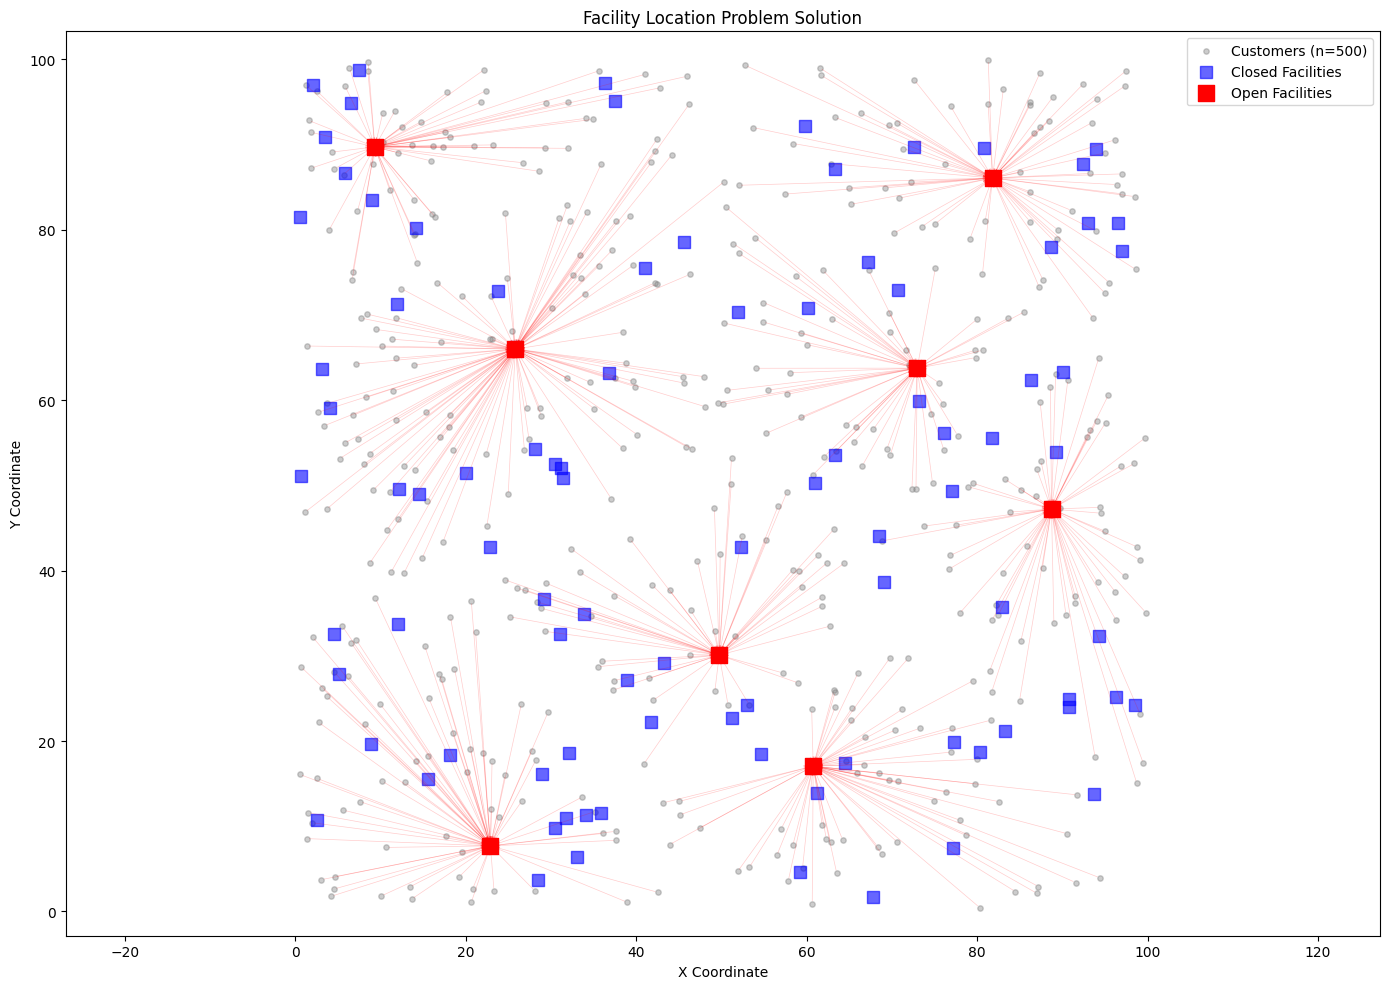


Solution Summary:
Total facilities opened:  8
Total opening cost:  $125,000
Total transportation cost:  $140,725
Total cost:  $265,725


In [8]:
# Visualize the solution
plt.figure(figsize=(14, 10))

# Plot customers in gray
plt.scatter(
    customer_locations[:, 0],
    customer_locations[:, 1],
    c="gray",
    s=15,
    alpha=0.4,
    label=f"Customers (n={p})",
)

# Plot all potential facilities in blue (closed facilities)
closed_facilities = np.where(xk == 0)[0]
if len(closed_facilities) > 0:
    plt.scatter(
        facility_locations[closed_facilities, 0],
        facility_locations[closed_facilities, 1],
        c="blue",
        s=80,
        marker="s",
        alpha=0.6,
        label="Closed Facilities",
    )

# Plot opened facilities in red
open_facilities = np.where(xk == 1)[0]
plt.scatter(
    facility_locations[open_facilities, 0],
    facility_locations[open_facilities, 1],
    c="red",
    s=120,
    marker="s",
    label="Open Facilities",
)

# Draw arrows from customers to their assigned facilities
for j in range(p):
    # Find which facility serves customer j
    assigned_facility = np.where(assignment[:, j] == 1)[0]
    if len(assigned_facility) > 0:
        facility_idx = assigned_facility[0]

        # Draw arrow from customer to facility
        plt.annotate(
            "",
            xy=facility_locations[facility_idx],
            xytext=customer_locations[j],
            arrowprops=dict(arrowstyle="->", color="red", alpha=0.2, lw=0.5),
        )

plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Facility Location Problem Solution")
plt.legend()
plt.axis("equal")
plt.tight_layout()
plt.show()

# Print solution summary
print(colored("\nSolution Summary:", "green", attrs=["bold"]))
print(colored("Total facilities opened: ", "green"), len(open_facilities))
print(colored("Total opening cost: ", "green"), f"${np.sum(facility_cost * xk):,.0f}")

# Calculate total transportation cost
total_transport_cost = sum(
    transportation_cost[np.where(assignment[:, j] == 1)[0][0], j] for j in range(p)
)

print(colored("Total transportation cost: ", "green"), f"${total_transport_cost:,.0f}")
print(
    colored("Total cost: ", "green"),
    f"${np.sum(facility_cost * xk) + total_transport_cost:,.0f}",
)

# Solve the orginial problem without decomposition to check if Benders Decomposition gives the same results

In [10]:
og = None
try:
    # Setup model
    og = Model(name="original problem")

    # Don't print Gurobi output
    og.setParam("OutputFlag", 0)

    # Set binary variables
    x_og = og.addVars(n, vtype=GRB.BINARY, name="x")

    # Set continuous variables
    y_og = og.addVars(n, p, vtype=GRB.CONTINUOUS, name="y")

    # Add auxiliary constraint
    og.addConstr(sum(x_og[i] for i in range(n)) >= 1)

    # Add constraints for variables y
    og.addConstrs(
        (y_og[i, j] <= x_og[i] for i in range(n) for j in range(p)),
        name="open facilities only",
    )
    og.addConstrs(
        (gp.quicksum(y_og[i, j] for i in range(n)) >= 1 for j in range(p)),
        name="demand fulfillment",
    )

    # Objective function
    og.setObjective(
        gp.quicksum(facility_cost[i] * x_og[i] for i in range(n))
        + gp.quicksum(
            transportation_cost[i, j] * y_og[i, j] for i in range(n) for j in range(p)
        ),
        GRB.MINIMIZE,
    )
    og.optimize()
    print(
        colored("\nOriginal problem objective:", "green", attrs=["bold"]),
        f"${og.objVal:,.0f}",
    )
finally:
    if og is not None:
        og.dispose()


Original problem objective: $265,725
